<a href="https://colab.research.google.com/github/AstronomerAmber/LLM_Observability/blob/main/Chronos_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronos: Learning the Language of Time Series
Chronos is a family of pretrained time series forecasting models based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss. Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes.

For details on Chronos models, training data and procedures, and experimental results, please refer to the paper [Chronos: Learning the Language of Time Series](https://arxiv.org/abs/2403.07815).

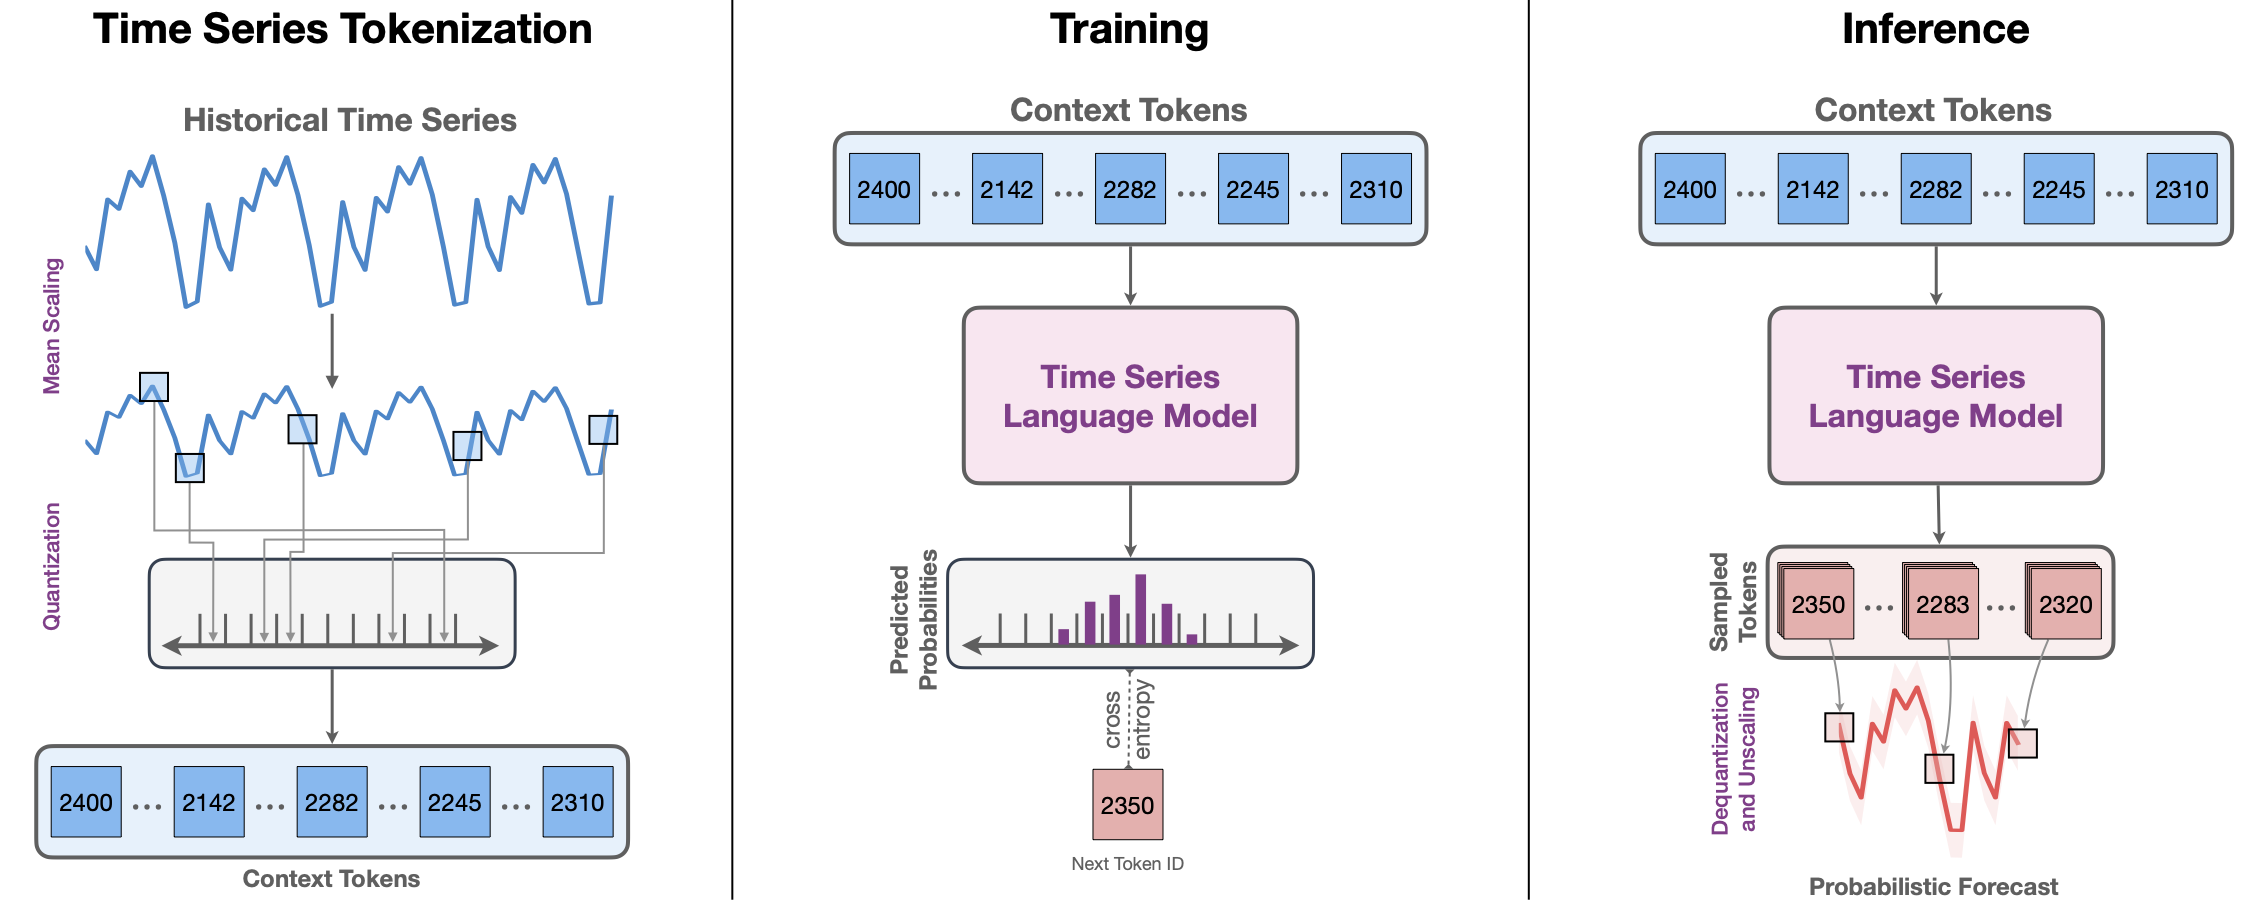

Fig. 1: High-level depiction of Chronos. (Left) The input time series is scaled and quantized to obtain a sequence of tokens. (Center) The tokens are fed into a language model which may either be an encoder-decoder or a decoder-only model. The model is trained using the cross-entropy loss. (Right) During inference, we autoregressively sample tokens from the model and map them back to numerical values. Multiple trajectories are sampled to obtain a predictive distribution.

In [2]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-wrki9z6a
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-wrki9z6a
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 96cedec3fa9795c9bd58650080643e2b68bd3a6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline

In [47]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)


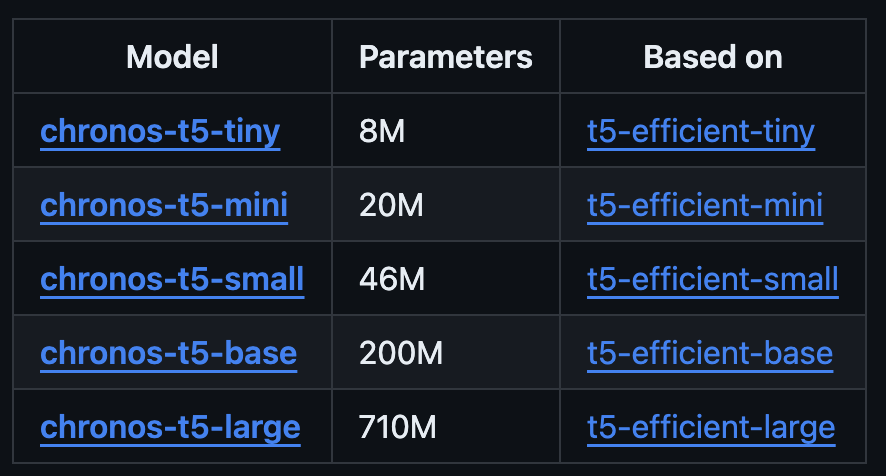

In [48]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")


In [42]:
display(df)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


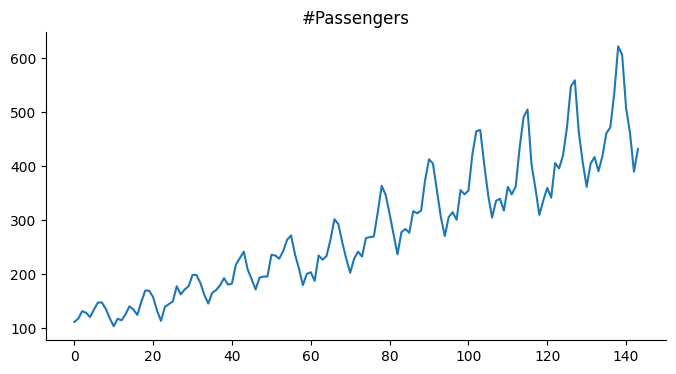

In [7]:
# @title #Passengers

from matplotlib import pyplot as plt
df['#Passengers'].plot(kind='line', figsize=(8, 4), title='#Passengers')
plt.gca().spines[['top', 'right']].set_visible(False)

In [50]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
prediction_length = 12
forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=20,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]

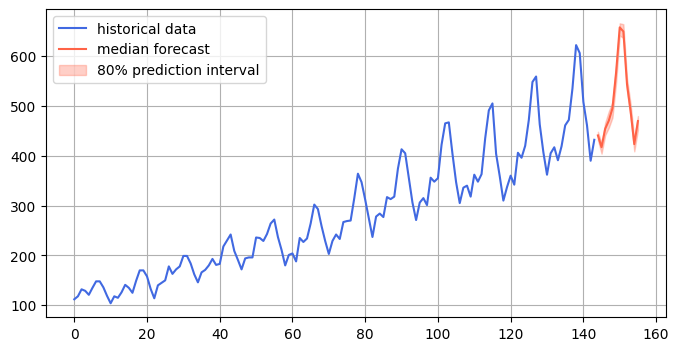

In [51]:
# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

# ARIMA

In [10]:
df_walmart = pd.read_csv('https://raw.githubusercontent.com/liamarguedas/walmart-sales-forecast/main/Data/train.csv')

In [11]:
display(df_walmart)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [12]:
df_walmart["Weekly_Sales"].max()

693099.36

In [13]:
df_walmart["Weekly_Sales"].min()

-4988.94

In [16]:
len(df_walmart["Weekly_Sales"])

421570

In [17]:
len(df_walmart["Weekly_Sales"][:-100])

421470

In [40]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df_walmart["Weekly_Sales"][:-25])
prediction_length = 25
forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=20,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]

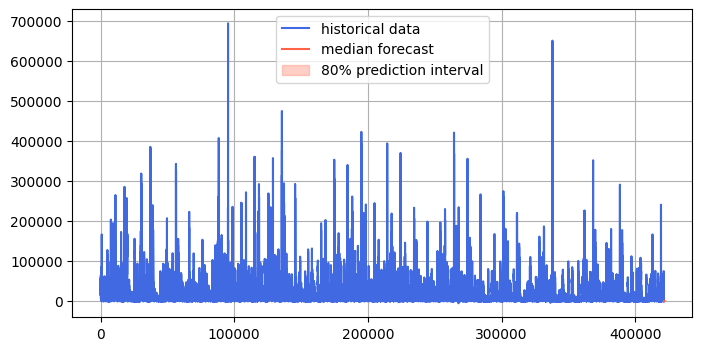

In [41]:
# visualize the forecast
forecast_index = range(len(df_walmart["Weekly_Sales"][:-25]), len(df_walmart["Weekly_Sales"][:-25]) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df_walmart["Weekly_Sales"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

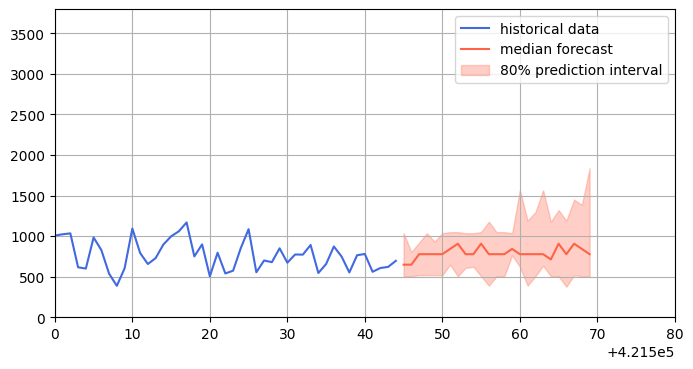

In [45]:
# visualize the forecast
forecast_index = range(len(df_walmart["Weekly_Sales"][:-25]), len(df_walmart["Weekly_Sales"][:-25]) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df_walmart["Weekly_Sales"][:-25], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.xlim(421500, 421580)
plt.ylim(0, 3800)
plt.legend()
plt.grid()
plt.show()


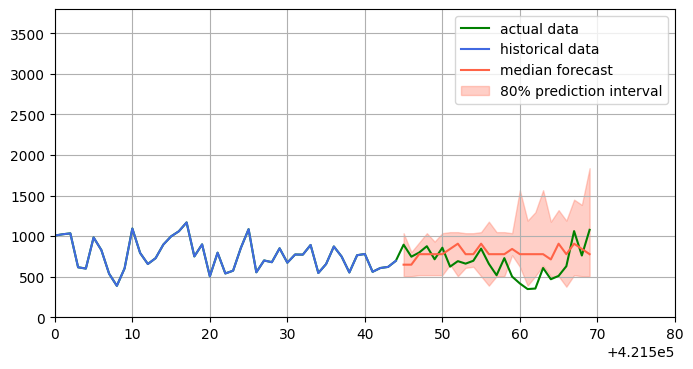

In [49]:
# visualize the forecast
forecast_index = range(len(df_walmart["Weekly_Sales"][:-25]), len(df_walmart["Weekly_Sales"][:-25]) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df_walmart["Weekly_Sales"], color="green", label="actual data")
plt.plot(df_walmart["Weekly_Sales"][:-25], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.xlim(421500, 421580)
plt.ylim(0, 3800)
plt.legend()
plt.grid()
plt.show()

In [37]:
df_arima = pd.read_csv('/content/arima.csv')

In [38]:
display(df_arima)

,Date,ModelPrediction,ActualValue,Difference,Difference%,Unnamed: 5,Unnamed: 6
0,2012-05-20,13901.882838,13885.275812,16.607025,0.12,NaN,NaN
1,2012-09-02,14290.768090,14334.458377,-43.690288,0.30,NaN,NaN
2,2012-09-16,14170.790140,14116.042424,54.747716,0.39,NaN,NaN
3,2012-04-29,13264.088080,13341.939822,-77.851742,0.58,NaN,NaN
4,2012-06-17,14525.886083,14631.211990,-105.325907,0.72,NaN,NaN
5,2012-09-09,14339.615925,14227.741508,111.874417,0.79,NaN,NaN
6,2012-05-13,13962.688831,13841.218610,121.470221,0.88,NaN,NaN
7,2012-06-10,14549.901223,14736.944981,-187.043758,1.27,NaN,NaN
8,2012-08-05,13765.117714,13580.951166,184.166548,1.36,NaN,NaN
9,2012-07-08,14467.416039,14256.616932,210.799107,1.48,NaN,NaN


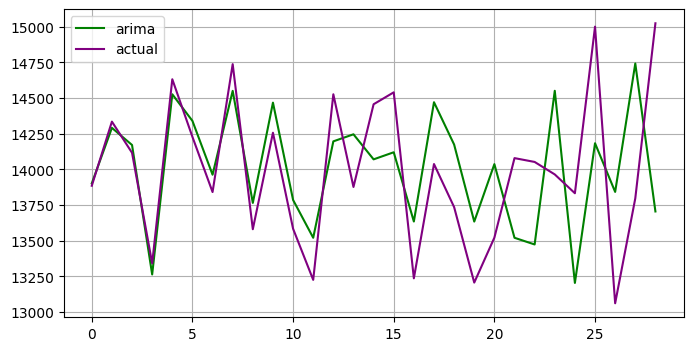

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(df_arima["ModelPrediction"], color="green", label="arima")
plt.plot(df_arima["ActualValue"], color="purple", label="actual")
#plt.plot(median+13000, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

In [59]:
median

array([831.90830109, 831.90830109, 831.90830109, 895.90123231,
       767.91536986, 895.90123231, 639.9295074 ])

In [60]:
forecast_index

range(421570, 421577)

21569	45	98	2012-10-26	1076.80	False
421570 rows × 5 columns